# **GIẢM NHIỄU BẰNG CÁCH SỬ DỤNG VECTO NỐI CÁC LỘ TRÌNH**

In [ ]:
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import folium
import math
from datetime import timedelta
import random
import networkx as nx
#Thư viện quy đổi tọa độ -> met
from haversine import haversine, Unit
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

import osmnx as ox, geopandas as gpd
import seaborn as sns
%matplotlib inline
ox.config(log_console=True, use_cache=True)

## Load data

In [ ]:
data = pd.read_csv('data_pre.csv')
data.head()

,vehicle,level_1,datetime,speed,y,x,heading,vehicleType,time_interval,distance,heading_interval
0,14B02190,0,2018-04-24 22:39:49,14.0,106.697784,10.786592,226.266560,100,20.0,11.221452,0.000000
1,14B02190,1,2018-04-24 22:40:09,5.0,106.697710,10.786522,224.953206,100,10.0,64.213887,1.313354
2,14B02190,2,2018-04-24 22:40:19,24.0,106.697296,10.786112,222.701121,100,30.0,110.879986,2.252085
3,14B02190,3,2018-04-24 22:40:49,24.0,106.696610,10.785377,221.411063,100,10.0,62.981940,1.290059
4,14B02190,4,2018-04-24 22:40:59,17.0,106.696230,10.784951,224.228675,100,40.0,109.985633,2.817612


In [ ]:
data["vehicle"].value_counts()

51F33308     494
51G48323     472
51G50101     438
51C31679     404
51F85909     400
            ... 
51G53268       5
51G43866       5
51C57019       4
50LD00479      3
51C59948       3
Name: vehicle, Length: 5856, dtype: int64

In [ ]:
data.groupby("vehicle")

In [ ]:
df = data[data['vehicle']=='51G48323']

In [ ]:
df

,vehicle,level_1,datetime,speed,y,x,heading,vehicleType,time_interval,distance,heading_interval
185369,51G48323,0,2018-04-24 17:37:22,34.0,106.675260,10.765490,340.112295,300,1.0,9.689041,143.938636
185370,51G48323,1,2018-04-24 17:37:23,35.0,106.675230,10.765572,334.521036,300,1.0,10.211302,5.591258
185371,51G48323,2,2018-04-24 17:37:24,35.0,106.675190,10.765655,341.105315,300,3.0,30.536642,6.584279
185372,51G48323,3,2018-04-24 17:37:27,36.0,106.675100,10.765915,347.607300,300,1.0,10.243260,6.501986
185373,51G48323,4,2018-04-24 17:37:28,36.0,106.675080,10.766005,342.501752,300,6.0,64.320282,5.105548
...,...,...,...,...,...,...,...,...,...,...,...
185836,51G48323,11,2018-04-24 19:02:11,19.0,106.674230,10.767908,183.536318,300,2.0,8.912358,24.027679
185837,51G48323,12,2018-04-24 19:02:13,15.0,106.674225,10.767828,194.019661,300,3.0,11.341999,10.483344
185838,51G48323,13,2018-04-24 19:02:16,12.0,106.674200,10.767729,183.525334,300,7.0,35.760421,10.494327
185839,51G48323,14,2018-04-24 19:02:23,20.0,106.674180,10.767408,209.842773,300,3.0,18.750498,26.317439


## Hàm vẽ map trực quan

In [ ]:
ef add_point(mapobj, df, colors):
    #Nạp x,y từ dataframe vào list coords
    coords = list(zip(df.x, df.y))
    
    #Hiển thị trên mapobj
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 1.5, 
                            fill = True,
                            fill_opacity = 0.75,
                            color = colors,
                            weight = 0.01).add_to(mapobj)
        
        
def add_lines(mapobj, df, colors):
    coords = list(zip(df.x, df.y))
    folium.PolyLine(coords, color=colors, weight=1, opacity=1).add_to(mapobj)   
       
    

def show_n_route(df, n, type_map):
    '''
    Hàm hiển thị map.
    Tùy chọn:
    - df: dataframe input
    - n: Số lộ trình cần hiển thị
    - type_map: dạng đường (1) và dạng điểm (0)
    '''
    colors = [
        'red',
        'yellow',
        'blue',
        'orange',
        'green',
        'lightgreen',
        'purple',
        'pink']
    #Khởi tạo bản đồ mapobj
    f = folium.Figure(height = 800)
    mapobj = folium.Map([np.median(df.x), np.median(df.y)], zoom_start = 15, tiles='Cartodb dark_matter')
    mapobj.add_to(f)


    #Hiển thị n lộ trình đầu tiên
    index_route = df[df['level_1'] == 0].index
    
    if n == -1 or n> len(index_route)-1:
        n = len(index_route)-1
    
    #Biến đếm màu
    t = 0
    if len(index_route)==1:
        if type_map == 0:
            add_point(mapobj, df, colors[t])
        else:
            add_lines(mapobj, df, colors[t])
        return mapobj
    
    for i in range(n):
        if i == len(index_route):
            df_temp = df.loc[index_route[i]:,['x', 'y']]
            if type_map == 0:
            #df_temp = df.loc[index_route[i]:index_route[i + 1],['x', 'y']]
                add_point(mapobj, df_temp, colors[t])
            else:
                #df_temp = df.loc[index_route[i]:index_route[i + 1] -1,['x', 'y']]
                add_lines(mapobj, df_temp, colors[t])
                add_point(mapobj, df_temp, colors[t])
        else:
            df_temp = df.loc[index_route[i]:index_route[i + 1] -1 ,['x', 'y']]
            if type_map == 0:
                add_point(mapobj, df_temp, colors[t])
            else:
                add_lines(mapobj, df_temp, colors[t])
                add_point(mapobj, df_temp, colors[t])
        t += 1
        if t == 8:
            t = 0
        
    return mapobj

In [ ]:
def add_markers(gdf):
    f = folium.Figure(height = 800)
    mapobj = folium.Map([np.median(gdf.x), np.median(gdf.y)], zoom_start = 15, tiles='Cartodb dark_matter')
    mapobj.add_to(f)
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.x, row.y])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj

In [ ]:
add_markers(df)

In [ ]:
show_n_route(df,-1,1)

## Hàm tính khoảng cách trong gps

In [ ]:
class GEPoint2D:

        def __init__(self, px, py):
            self.x = px
            self.y = py
        

def Distance(p1, p2):

    # GEPoint2D p1, GEPoint2D p2

    if p1 == p2:
        return 0

    dbLat1InRad = p1.y * (math.pi / 180.0)
    dbLong1InRad = p1.x * (math.pi / 180.0)
    dbLat2InRad = p2.y * (math.pi / 180.0)
    dbLong2InRad = p2.x * (math.pi / 180.0)

    dbTheta = p1.x - p2.x
    dbThetaInRad = dbTheta * (math.pi / 180.0)

    a = math.sin(dbLat1InRad)
    b = math.sin(dbLat2InRad)
    c = math.cos(dbLat1InRad)
    d = math.cos(dbLat2InRad)
    e = math.cos(dbThetaInRad)
    f = a * b + c * d * e

    if f > 1:
        f = 1
    if f < -1:
        f = -1

    dbDistInRad = math.acos(f)
    dbDist = dbDistInRad * 180.0 / math.pi
    dbDist = dbDist * 60.0 * 1.1515
    dbDist = dbDist * 1.609344 * 1000

    return dbDist

def direct_point(A,A_next): 
    return geod.Inverse(float(A.x),float(A.y),float(A_next.x),float(A_next.y))['azi1']

def Line2D(p1,p2):
    #a = p1.y - p2.y
    #b = p2.x - p1.x
    #c = -a * p1.x - b * p1.y
    x = (p1.x ,p1.y)
    y = (p2.x, p2.y)
    coef = np.polyfit(x, y, 1)
    a = coef[0]
    b = coef[1]
    c = a*x[0] + b*x[1]
    
    return a, b, c

class Point2D:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
class Vector2D:
    
    def __init__(self,point1, point2):
        self.p1 = point1
        self.p2 = point2
        self.vx = point1.x - point2.x
        self.vy = point1.y - point2.y
        
    def Distance(self,p):
        a, b, c = Line2D(point2,p)
        distance = abs(a*p.x + b*p.y + c)/((a*a+b*b)**(1/2))
        distance = distance / 0.00000833
        return distance
    
    def Angle(self,v1):
        self.cost = self.vx * self.vx + self.vx * self.vy
        
        
def shortest_distance(x1, y1, a, b, c):
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d

def distance_p3_with_line(p1, p2, p3):
    A =  GEPoint2D(p1.x,p1.y)
    B = GEPoint2D(p2.x,p2.y)
    C = GEPoint2D(p3.x,p3.y)
    a = Distance(B,C)
    b = Distance(A,C)
    c = Distance(A,B)
    cosAngleA = (b*b +c*c -a*a) / (2*b*c)
#     if cosAngleA > 1.0:
#         cosAngle = 1
#     if cosAngleA < -1.0:
#         cosAngle = -1
    cosAngleA = round(cosAngleA,4)
    print(cosAngleA)
    angleA = math.acos(cosAngleA)
    distance_p3 = b * math.sin(angleA)
    return distance_p3


p1 = Point2D(106.696495,10.766200)

## Hàm xử lý bằng vecto

In [ ]:

def route(df):
    '''
    
    '''
    d_max = 15
    # Danh sách các số xe
    list_vehicle = list(set(df.vehicle))
    list_all_route_vehicle = pd.DataFrame()
    for vehicle in list_vehicle:
        # DataFrame các lộ trình của từng xe
        df1 = df[df.vehicle == vehicle]
        # danh sách các điểm đầu của từng lộ trình của mỗi xe
        list_idx_route = df1[df1.level_1 == 0].index
        # Khởi tạo list danh sách các lộ trình
        list_route  = []
        
        vector = 0
        # Sử dụng vòng for với danh sách các điểm đầu lộ trình
        for i in range(len(list_idx_route)):
            # nếu lộ trình ở cuối danh sách thì list_route append phần còn lại trong dataFrame lộ trình df1
            if i == len(list_idx_route) - 1:
                list_route.append(df1.loc[list_idx_route[i]:])
            else:
            # nếu lộ trình không ở cuối thì list_route append điểm đầu lộ trình và điểm đầu lộ trình tiếp theo - 1
                list_route.append(df1.loc[list_idx_route[i]:list_idx_route[i+1]-1])
                
        # Nối các lộ trình của từng xe
        for i in range(len(list_route)-1,-1,-1):
            # nếu lộ trình đang xét chỉ có 1 điểm thì ta sẽ nối nó vào lộ trình trước đó
            if len(list_route[i]) == 1:
                if len(list_route[i-1]) == 1:
                    list_route[i]['level_1'] = 1 #max(list_route[i-1].level_1) + 1
                    list_route[i-1] = list_route[i-1].append(list_route[i])
                else:
                    d = distance_p3_with_line(list_route[i-1].iloc[-2], list_route[i-1].iloc[-1], list_route[i].iloc[0])
                    if d < d_max:
                        list_route[i]['level_1'] = max(list_route[i-1].level_1) + 1
                        list_route[i-1] = list_route[i-1].append(list_route[i])
            
            # nếu lộ trình trước của lộ trình đang xét chỉ có 1 điểm 
            # ta xét vector lộ trình hiện tại có đi qua điểm của lộ trình trước đó ko
            elif len(list_route[i-1]) == 1:
                d= distance_p3_with_line(list_route[i].iloc[0], list_route[i].iloc[1], list_route[i-1].iloc[0])
                
                if d < d_max:
                    max_level = max(list_route[i-1].level_1) + 1
                    for j in list_route[i].index:
                        list_route[i].at[j, 'level_1'] = max_level         
                        list_route[i-1] = list_route[i-1].append(list_route[i].loc[j])
                        max_level += 1
                        
            # nếu cả 2 lộ trình đều chứa nhiều điểm ta xét 2 vector của chúng
            else:
                vector_a = direct_point(list_route[i].iloc[0], list_route[i].iloc[1])
                vector_b = direct_point(list_route[i-1].iloc[-2], list_route[i-1].iloc[-1])
                g = vector_a - vector_b
                if g >180: g = g - 180
                if g <0: g = g + 180
                
                # nếu 2 lộ trình không quá chênh lệch vecto ta sẽ nối lại
                if g < 25:
                    max_level = max(list_route[i-1].level_1) + 1
                    for j in list_route[i].index:
                        list_route[i].at[j, 'level_1'] = max_level         
                        list_route[i-1] = list_route[i-1].append(list_route[i].loc[j])
                        max_level += 1
                
                # nếu 2 lộ trình 
                elif  g < 120:
                    L1 = line([list_route[i  ].iloc[0 ].x, list_route[i  ].iloc[0 ].y], [list_route[i  ].iloc[1 ].x, list_route[i  ].iloc[1 ].y])
                    L2 = line([list_route[i-1].iloc[-1].x, list_route[i-1].iloc[-1].y], [list_route[i-1].iloc[-2].x, list_route[i-1].iloc[-2].y])

                    R = intersection(L1, L2)
                    if R:
                        max_level = max(list_route[i-1].level_1) + 1
                        if Distance(list_route[i].iloc[0], GEPoint2D(R[0], R[1])) + Distance(list_route[i].iloc[1], GEPoint2D(R[0], R[1])) != Distance(list_route[i].iloc[0], list_route[i].iloc[1]) and \
                        Distance(list_route[i-1].iloc[-1], GEPoint2D(R[0], R[1])) + Distance(list_route[i-1].iloc[-2], GEPoint2D(R[0], R[1])) != Distance(list_route[i-1].iloc[-1], list_route[i-1].iloc[-2]):
                            
                            
                            point_middle = list_route[i].iloc[0]
                            point_middle.x = R[0]
                            point_middle.y = R[1]
                            point_middle.level_1 = max_level
                            point_middle.datetime = list_route[i-1].iloc[-1].datetime + (list_route[i].iloc[0].datetime - list_route[i-1].iloc[-1].datetime) /2

                            list_route[i-1] = list_route[i-1].append(point_middle, ignore_index = True)
                            max_level += 1
                            
                        for j in list_route[i].index:
                            list_route[i].at[j, 'level_1'] = max_level
                            list_route[i-1] = list_route[i-1].append(list_route[i].loc[j])
                            max_level += 1

                    
        for k in list_route:
            if k.iloc[0].level_1 == 0:
                list_all_route_vehicle = list_all_route_vehicle.append(k, ignore_index = True)
    return list_all_route_vehicle
    #return list_route
list_route = route(df)
list_route

0.9003
-0.1934
-0.8081
0.8359
0.9999
0.1907
1.0
-0.9702
0.9179
1.0
0.6024
-0.9072
-0.9112

<ipython-input-12-c928b89850a1>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_route[i]['level_1'] = 1 #max(list_route[i-1].level_1) + 1



-0.9572
-0.9346
-0.9357
-0.5952
-0.1688
0.9838
-0.3651
-0.8316
-0.5619
-0.8593
0.3905
-0.9781
-0.9722
-0.061
-0.9466
0.2327
0.5437
-0.5418
-0.2948
-0.912
0.9678


In [ ]:
list_route1

,vehicle,level_1,datetime,speed,y,x,heading,vehicleType,time_interval,distance,heading_interval
185369,51G48323,0,2018-04-24 17:37:22,34.0,106.675260,10.765490,340.112295,300,1.0,9.689041,143.938636
185370,51G48323,1,2018-04-24 17:37:23,35.0,106.675230,10.765572,334.521036,300,1.0,10.211302,5.591258
185371,51G48323,2,2018-04-24 17:37:24,35.0,106.675190,10.765655,341.105315,300,3.0,30.536642,6.584279
185372,51G48323,3,2018-04-24 17:37:27,36.0,106.675100,10.765915,347.607300,300,1.0,10.243260,6.501986
185373,51G48323,4,2018-04-24 17:37:28,36.0,106.675080,10.766005,342.501752,300,6.0,64.320282,5.105548
185374,51G48323,5,2018-04-24 17:37:34,39.0,106.674904,10.766557,339.091596,300,1.0,10.466321,3.410156
185375,51G48323,6,2018-04-24 17:37:35,38.0,106.674870,10.766645,338.277092,300,3.0,32.647967,0.814504
185376,51G48323,7,2018-04-24 17:37:38,39.0,106.674760,10.766918,338.805769,300,2.0,21.270325,0.528677
185377,51G48323,8,2018-04-24 17:37:40,35.0,106.674690,10.767096,339.299459,300,1.0,9.323719,0.493689
185378,51G48323,9,2018-04-24 17:37:41,32.0,106.674660,10.767175,346.247300,300,3.0,23.115942,6.947841


In [ ]:
pd.set_option('display.max_rows', None)

## Trực quan đường phố các lộ trình bằng thư viện osmnx của Python

#### Trực quan bản đồ các giao lộ trong không gian di chuyển của các xe

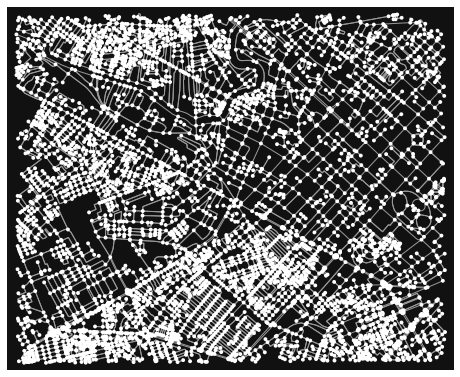

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
north, south, east, west = data.x.max(), data.x.min(), data.y.max(), data.y.min()
# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west)
G1 = ox.project_graph(G1)
ox.plot_graph(G1)

#### Ví dụ vẽ đường đi của 2 điểm từ dữ liệu về lộ trình của một xe

In [ ]:
p1 = df.loc[185695]
p2 = df.loc[185710]

Đầu tiên ta tạo 2 điểm p_org và p_des là 2 tuple như dưới đây

In [ ]:
p_org = (p1.x,p1.y)
p_des = (p2.x,p2.y)

Sau đó ta tạo bản đồ để trực quan đường đi dựa vào location_point là điểm ở giữa về mặt địa lý của 2 điểm p_org và p_des đồng thời là điểm trung tâm của bản đồ G1.

Từ 2 điểm p_org và p_des ta được 2 biến là origin_node và destination_node là 2 điểm trên bản đồ G1, sau đó ta xác định đường đi route là đường đi ngắn nhất của 2 điểm với thư viện networkx với hàm shortest_path dựa trên 2 tiêu chí tìm đường là length là độ dài ngắn nhất của đường hoặc travel_time là thời gian ngắn nhất để đi giữa 2 điểm.

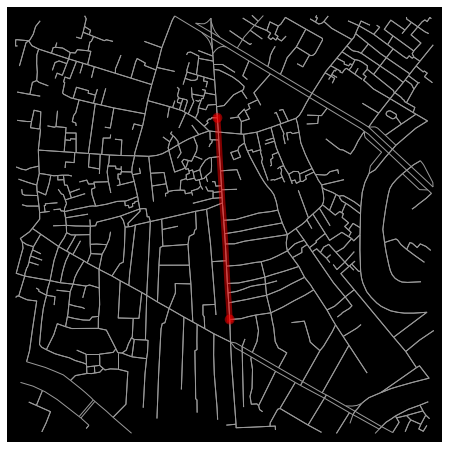

In [ ]:
location_point = ((p1.x + p2.x)/2, (p1.y+p2.y)/2)
G1 = ox.graph_from_point(location_point, dist=500, clean_periphery=False)
origin_node = ox.get_nearest_node(G1, p_org)
destination_node = ox.get_nearest_node(G1, p_des)
route_length = nx.shortest_path(G1, origin_node, destination_node,weight='length')
fig, ax = ox.plot_graph_route(G1, route_length, route_linewidth=6, node_size=0, bgcolor='k')

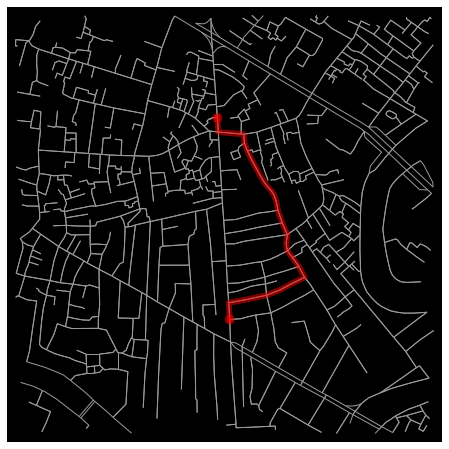

In [ ]:
route_travel_time = nx.shortest_path(G1, origin_node, destination_node,weight='travel_time')
fig, ax = ox.plot_graph_route(G1, route_travel_time, route_linewidth=6, node_size=0, bgcolor='k')

In [ ]:
type(route_travel_time[0])

numpy.int64

In [ ]:
gps_coordinate_node_ = [G1.nodes[route_length[i]] for i in range(len(route_length))]

In [ ]:
# G2 = ox.consolidate_intersections(G1, tolerance=10, rebuild_graph=True, dead_ends=True)
gps_coordinate_node_

[{'y': 10.792466, 'x': 106.6779761},
 {'y': 10.792161, 'x': 106.6779981, 'highway': 'traffic_signals'},
 {'y': 10.7919903, 'x': 106.6780069},
 {'y': 10.7916331, 'x': 106.6780259},
 {'y': 10.7913253, 'x': 106.6780454},
 {'y': 10.7910093, 'x': 106.6780654},
 {'y': 10.7909212, 'x': 106.6780707},
 {'y': 10.7908837, 'x': 106.6780728},
 {'y': 10.790752, 'x': 106.6780802},
 {'y': 10.7906381, 'x': 106.6780871},
 {'y': 10.790265, 'x': 106.6781154},
 {'y': 10.7899765, 'x': 106.6781355},
 {'y': 10.7897581, 'x': 106.6781511},
 {'y': 10.7893978, 'x': 106.67817},
 {'y': 10.7892822, 'x': 106.6781758},
 {'y': 10.7889085, 'x': 106.6781952},
 {'y': 10.7887065, 'x': 106.6782093},
 {'y': 10.7884931, 'x': 106.6782254},
 {'y': 10.7881348, 'x': 106.6782468}]

In [ ]:
df_coordinates_nodes = pd.DataFrame(gps_coordinate_node_)

In [ ]:
df_coordinates_nodes= df_coordinates_nodes.rename(columns={'y':'x','x':'y'})

In [ ]:
df_coordinates_nodes

,x,y,highway
0,10.792466,106.677976,NaN
1,10.792161,106.677998,traffic_signals
2,10.791990,106.678007,NaN
3,10.791633,106.678026,NaN
4,10.791325,106.678045,NaN
5,10.791009,106.678065,NaN
6,10.790921,106.678071,NaN
7,10.790884,106.678073,NaN
8,10.790752,106.678080,NaN
9,10.790638,106.678087,NaN


In [ ]:
add_markers(df_coordinates_nodes)

In [ ]:
show_n_route(df,-1,1)

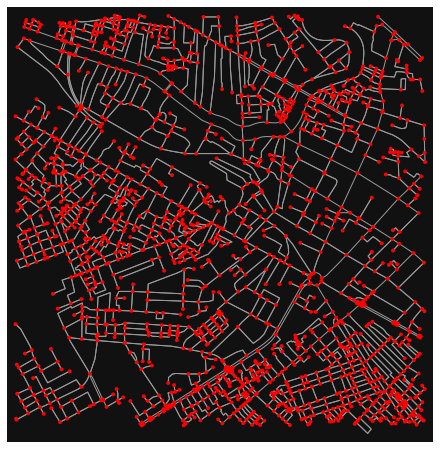

In [ ]:
mean_point = (df.x.median(),df.y.median())
G = ox.graph_from_point(mean_point, dist=1000, clean_periphery=True)
fig, ax = ox.plot_graph(G, node_color='r')

In [ ]:

# convert your MultiDiGraph to an undirected MultiGraph
M = ox.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.get_digraph(G)

In [ ]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()
gdf_exam = gdf_nodes
gdf_exam = gdf_exam.rename(columns={'y':'x','x':'y'})

In [ ]:
gdf_exam

,x,y,street_count,highway,geometry
osmid,,,,,
366368374,10.781224,106.675257,3,NaN,POINT (106.67526 10.78122)
366368517,10.778955,106.672764,3,NaN,POINT (106.67276 10.77896)
366380943,10.779058,106.669539,4,NaN,POINT (106.66954 10.77906)
366381280,10.789169,106.668791,3,NaN,POINT (106.66879 10.78917)
366388492,10.778472,106.672359,3,NaN,POINT (106.67236 10.77847)
366397796,10.780237,106.674488,3,NaN,POINT (106.67449 10.78024)
366398003,10.779500,106.670832,3,NaN,POINT (106.67083 10.77950)
366401260,10.778665,106.672881,3,NaN,POINT (106.67288 10.77866)
366401737,10.779098,106.674022,3,NaN,POINT (106.67402 10.77910)


In [ ]:
add_markers(gdf_exam)